# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

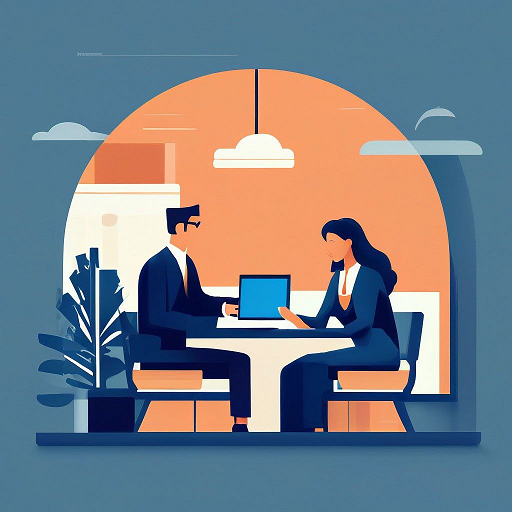

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Востановление-пропусков-линейными-моделями" data-toc-modified-id="Востановление-пропусков-линейными-моделями-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Востановление пропусков линейными моделями</a></span></li><li><span><a href="#Подытог" data-toc-modified-id="Подытог-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Подытог</a></span></li></ul></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span><ul class="toc-item"><li><span><a href="#Подытог" data-toc-modified-id="Подытог-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подытог</a></span></li></ul></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span><ul class="toc-item"><li><span><a href="#Лучшая-модель" data-toc-modified-id="Лучшая-модель-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Лучшая модель</a></span></li><li><span><a href="#Тестирование-моделей,-которые-мы-откинули" data-toc-modified-id="Тестирование-моделей,-которые-мы-откинули-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Тестирование моделей, которые мы откинули</a></span></li><li><span><a href="#Подытог" data-toc-modified-id="Подытог-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Подытог</a></span></li><li><span><a href="#Вариант-до-обучения-модели-на-валидационной-выборке-перед-тестированием" data-toc-modified-id="Вариант-до-обучения-модели-на-валидационной-выборке-перед-тестированием-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Вариант до-обучения модели на валидационной выборке перед тестированием</a></span></li><li><span><a href="#Вариант-удаления-столбца-'Tenure'" data-toc-modified-id="Вариант-удаления-столбца-'Tenure'-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Вариант удаления столбца 'Tenure'</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

Признаки
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата  

Целевой признак
- Exited — факт ухода клиента

## Подготовка данных

In [152]:
import pandas as pd
import math
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sb
from joblib import dump
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.model_selection import GridSearchCV #попробуем автоподбор параметров
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_curve, roc_auc_score, make_scorer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier


pd.options.mode.chained_assignment = None


In [2]:
try:
    df = pd.read_csv('C://datasets/Churn.csv')
except:
    df = pd.read_csv('/datasets/Churn.csv')
    
display(df.info())
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


None

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


In [3]:
df.duplicated().sum()

0

In [4]:
df.query('Tenure.notna()').describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,9091.000000,9.091000e+03,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000
mean,5013.909911,1.569105e+07,650.736553,38.949181,4.997690,76522.740015,1.530195,0.704983,0.515565,100181.214924,0.203938
std,2884.433466,7.161419e+04,96.410471,10.555581,2.894723,62329.528576,0.581003,0.456076,0.499785,57624.755647,0.402946
min,1.000000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,2521.500000,1.562899e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.000000,0.000000,51227.745000,0.000000
50%,5019.000000,1.569106e+07,652.000000,37.000000,5.000000,97318.250000,1.000000,1.000000,1.000000,100240.200000,0.000000
75%,7511.500000,1.575285e+07,717.000000,44.000000,7.000000,127561.890000,2.000000,1.000000,1.000000,149567.210000,0.000000
max,9999.000000,1.581566e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [5]:
(df.query('Tenure.notna()').describe()/df.query('Tenure.isna()').describe()).T

,count,mean,std,min,25%,50%,75%,max
RowNumber,10.0011,1.030315,0.991349,0.032258,1.091086,1.027010,1.028128,0.999900
CustomerId,10.0011,1.000079,0.953429,0.999993,1.000154,1.000267,0.999749,0.999998
CreditScore,10.0011,1.003525,0.973063,0.974930,1.006897,1.007728,0.998607,1.000000
Age,10.0011,1.007794,1.078703,1.000000,1.000000,1.000000,1.023256,1.000000
Tenure,inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Balance,10.0011,1.005326,0.987701,NaN,NaN,1.006658,0.992275,1.214040
NumOfProducts,10.0011,0.999962,0.987342,1.000000,1.000000,1.000000,1.000000,1.000000
HasCrCard,10.0011,0.991996,1.005235,NaN,NaN,1.000000,1.000000,1.000000
IsActiveMember,10.0011,1.010018,0.999239,NaN,NaN,1.000000,1.000000,1.000000
EstimatedSalary,10.0011,1.010091,1.022113,0.108559,1.027178,1.008006,1.026122,1.003019


Учебне пропуски, где взяли ровно 1 часть к 10 и выбрали ровно так, чтоб не нарушать никакие средние.
В данном случае заполнить пропуски каким-то одним значением мы не можем.
    
У нас есть 3 варианта:
    
    1) Удалить пропуски
    
    2) Удалить столбец
    
    3) Заполнить пропуски

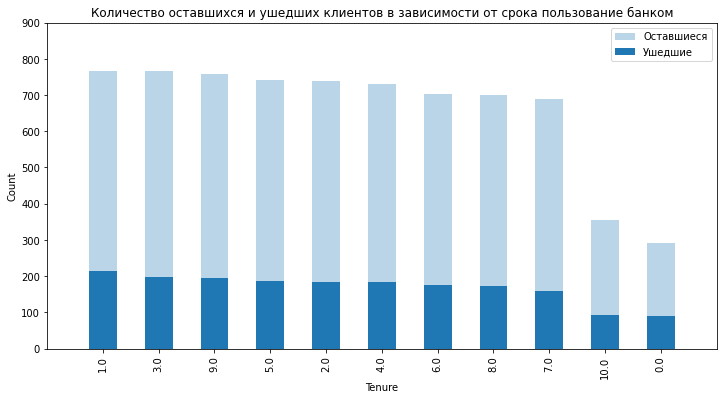

In [6]:
df.query('Exited == 0')['Tenure'].value_counts().plot(kind = 'bar', alpha = 0.3, figsize = (12,6), label = 'Оставшиеся')
df.query('Exited == 1')['Tenure'].value_counts().plot(kind = 'bar', label = 'Ушедшие')
plt.xlim([-1, 11])
plt.ylim([0, 900])
plt.xlabel('Tenure')
plt.ylabel('Count')
plt.title('Количество оставшихся и ушедших клиентов в зависимости от срока пользование банком')
plt.legend()
plt.show() 


In [7]:
df.Surname.value_counts()

Smith        32
Martin       29
Scott        29
Walker       28
Brown        26
             ..
Greenwood     1
Jolly         1
Traeger       1
Morton        1
Hodge         1
Name: Surname, Length: 2932, dtype: int64

In [8]:
df[df.Tenure == df.Tenure].corr()['Tenure']

RowNumber         -0.007322
CustomerId        -0.021418
CreditScore       -0.000062
Age               -0.013134
Tenure             1.000000
Balance           -0.007911
NumOfProducts      0.011979
HasCrCard          0.027232
IsActiveMember    -0.032178
EstimatedSalary    0.010520
Exited            -0.016761
Name: Tenure, dtype: float64

- Линейных кореляций между "Tenure" и другими данными нет. А значит мы можем построить модель, чтобы попытаться востановить значения.

Так же, учитывая нашу задачу, стоит удалить ещё несколько столбцов с данными, а именно:
    
    1) RowNumber - столбец просто лишний дубликат индекса, начинающийся с 1, а не с 0.
    2) CustomerId - по произовльно выдаваемому номеру точно не стоит пытаться предсказать поведение клиента.
    3) Surname - фамилию, в отличии от банка, так же не выбирают (бывают исключения, но очень редкие)
    



In [9]:
df.drop(['RowNumber','CustomerId','Surname'],axis=1,inplace=True)

In [10]:
cat_cols=['Geography','Gender']
num_cols=[col for col in df.columns if col not in cat_cols]

In [11]:
df[cat_cols] = df[cat_cols].astype('object')
df[cat_cols] = df[cat_cols].astype('object')

In [12]:
df[['HasCrCard', 'IsActiveMember', 'Exited']] = df[['HasCrCard', 'IsActiveMember', 'Exited']].astype('bool')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           9091 non-null   float64
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  bool   
 8   IsActiveMember   10000 non-null  bool   
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  bool   
dtypes: bool(3), float64(3), int64(3), object(2)
memory usage: 654.4+ KB


 - Приведем буквенные данные к нижнему регистру и заменим пробелы на нижнее подчеркивание.

In [14]:
df.columns = df.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]

/tmp/ipykernel_464/863562265.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df.columns = df.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]


In [15]:
df.head(15)

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2.0,0.00,1,True,True,101348.88,True
1,608,Spain,Female,41,1.0,83807.86,1,False,True,112542.58,False
2,502,France,Female,42,8.0,159660.80,3,True,False,113931.57,True
3,699,France,Female,39,1.0,0.00,2,False,False,93826.63,False
4,850,Spain,Female,43,2.0,125510.82,1,True,True,79084.10,False
5,645,Spain,Male,44,8.0,113755.78,2,True,False,149756.71,True
6,822,France,Male,50,7.0,0.00,2,True,True,10062.80,False
7,376,Germany,Female,29,4.0,115046.74,4,True,False,119346.88,True
8,501,France,Male,44,4.0,142051.07,2,False,True,74940.50,False
9,684,France,Male,27,2.0,134603.88,1,True,True,71725.73,False


### Востановление пропусков линейными моделями

- Попробуем востановить пропуске в столбце "tenure" с помощю простых алгоритмов;
- Для этого создадим отдельный набор данных, закодируем его, нормируем, разделим выборки и попробуем простые модели;
- Попробуем простейшие модели и сравним их с DummyClassifier.

In [16]:
recava_df = df[df.tenure == df.tenure]

In [17]:
recava_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9998
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      9091 non-null   int64  
 1   geography         9091 non-null   object 
 2   gender            9091 non-null   object 
 3   age               9091 non-null   int64  
 4   tenure            9091 non-null   float64
 5   balance           9091 non-null   float64
 6   num_of_products   9091 non-null   int64  
 7   has_cr_card       9091 non-null   bool   
 8   is_active_member  9091 non-null   bool   
 9   estimated_salary  9091 non-null   float64
 10  exited            9091 non-null   bool   
dtypes: bool(3), float64(3), int64(3), object(2)
memory usage: 665.8+ KB


In [18]:
encoder = OrdinalEncoder() 
encoder.fit(recava_df) 
recava_df = pd.DataFrame(encoder.transform(recava_df), columns=recava_df.columns) 
recava_df

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,226.0,0.0,0.0,24.0,2.0,0.0,0.0,1.0,1.0,4609.0,1.0
1,215.0,2.0,0.0,23.0,1.0,679.0,0.0,0.0,1.0,5119.0,0.0
2,109.0,0.0,0.0,24.0,8.0,5277.0,2.0,1.0,0.0,5182.0,1.0
3,306.0,0.0,0.0,21.0,1.0,0.0,1.0,0.0,0.0,4274.0,0.0
4,457.0,2.0,0.0,25.0,2.0,3374.0,0.0,1.0,1.0,3559.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
9086,407.0,0.0,0.0,11.0,2.0,0.0,1.0,0.0,0.0,7599.0,0.0
9087,378.0,0.0,1.0,21.0,5.0,0.0,1.0,1.0,0.0,4385.0,0.0
9088,123.0,0.0,1.0,17.0,10.0,110.0,0.0,1.0,1.0,4627.0,0.0
9089,316.0,0.0,0.0,18.0,7.0,0.0,0.0,0.0,1.0,1882.0,1.0


In [19]:
rnd = 12345

target = recava_df['tenure']
features = recava_df.drop(['exited', 'tenure'], axis=1)

features_train, features_subset, target_train, target_subset = train_test_split(
    features, target, test_size=0.40, random_state=rnd, stratify = target)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_subset, target_subset, test_size=0.5, random_state=rnd, stratify = target_subset)



In [20]:
numeric = ['credit_score', 'age', 'balance', 'num_of_products', 'estimated_salary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])



In [21]:
model1 = LinearRegression()
model2 = DecisionTreeClassifier()
model3 = RandomForestClassifier()
model4 = LogisticRegression()
model5 = DummyClassifier(strategy='stratified')

In [22]:
model1.fit(features_train, target_train)
model2.fit(features_train, target_train)
model3.fit(features_train, target_train)
model4.fit(features_train, target_train)
model5.fit(features_train, target_train)
None

In [23]:
pred1 = model1.predict(features_valid) 
score1 = model1.score(features_valid, target_valid)
pred2 = model2.predict(features_valid) 
score2 = model2.score(features_valid, target_valid)
pred3 = model3.predict(features_valid) 
score3 = model3.score(features_valid, target_valid)
pred4 = model4.predict(features_valid) 
score4 = model4.score(features_valid, target_valid)
pred5 = model5.predict(features_valid) 
score5 = model5.score(features_valid, target_valid)
model_scores = [score1,score2,score3,score4,score5]
[round(x,4) for x in model_scores]

[0.0009, 0.1012, 0.0963, 0.1139, 0.1007]

- Линейные модели, построенные на имеющихся данных, очень плохо справляются с пердсказанием значения столбца 'tenure'. В данном случае пропуски лучше просто удалить, чем пытаться заполнить. 

In [24]:
df.dropna(axis = 0, inplace = True)
df

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2.0,0.00,1,True,True,101348.88,True
1,608,Spain,Female,41,1.0,83807.86,1,False,True,112542.58,False
2,502,France,Female,42,8.0,159660.80,3,True,False,113931.57,True
3,699,France,Female,39,1.0,0.00,2,False,False,93826.63,False
4,850,Spain,Female,43,2.0,125510.82,1,True,True,79084.10,False
...,...,...,...,...,...,...,...,...,...,...,...
9994,800,France,Female,29,2.0,0.00,2,False,False,167773.55,False
9995,771,France,Male,39,5.0,0.00,2,True,False,96270.64,False
9996,516,France,Male,35,10.0,57369.61,1,True,True,101699.77,False
9997,709,France,Female,36,7.0,0.00,1,False,True,42085.58,True


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9998
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      9091 non-null   int64  
 1   geography         9091 non-null   object 
 2   gender            9091 non-null   object 
 3   age               9091 non-null   int64  
 4   tenure            9091 non-null   float64
 5   balance           9091 non-null   float64
 6   num_of_products   9091 non-null   int64  
 7   has_cr_card       9091 non-null   bool   
 8   is_active_member  9091 non-null   bool   
 9   estimated_salary  9091 non-null   float64
 10  exited            9091 non-null   bool   
dtypes: bool(3), float64(3), int64(3), object(2)
memory usage: 665.8+ KB


### Подытог

- Данные подготовлены для дальнейшего использования в моделях

## Исследование задачи

In [26]:
f"Банк покинуло {df['exited'].mean():.1%} клиентов"

'Банк покинуло 20.4% клиентов'

- Присутствует явный дисбаланс классов;
- Выполним кодирование и масштабирование данных.

In [27]:
encoder = OrdinalEncoder() 
encoder.fit(df) 
df_ordinal = pd.DataFrame(encoder.transform(df), columns=df.columns) 
df_ordinal

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,226.0,0.0,0.0,24.0,2.0,0.0,0.0,1.0,1.0,4609.0,1.0
1,215.0,2.0,0.0,23.0,1.0,679.0,0.0,0.0,1.0,5119.0,0.0
2,109.0,0.0,0.0,24.0,8.0,5277.0,2.0,1.0,0.0,5182.0,1.0
3,306.0,0.0,0.0,21.0,1.0,0.0,1.0,0.0,0.0,4274.0,0.0
4,457.0,2.0,0.0,25.0,2.0,3374.0,0.0,1.0,1.0,3559.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
9086,407.0,0.0,0.0,11.0,2.0,0.0,1.0,0.0,0.0,7599.0,0.0
9087,378.0,0.0,1.0,21.0,5.0,0.0,1.0,1.0,0.0,4385.0,0.0
9088,123.0,0.0,1.0,17.0,10.0,110.0,0.0,1.0,1.0,4627.0,0.0
9089,316.0,0.0,0.0,18.0,7.0,0.0,0.0,0.0,1.0,1882.0,1.0


- Проведем разбиение на три выборки - обучающую, валидационную и тестировочную. Проведем стратификацию; 
    
- После этого проведем их масштабирование.


In [28]:
rnd = 12345

target = df_ordinal['exited']
features = df_ordinal.drop('exited', axis=1)

features_train, features_subset, target_train, target_subset = train_test_split(
    features, target, test_size=0.40, random_state=rnd, stratify = target)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_subset, target_subset, test_size=0.5, random_state=rnd, stratify = target_subset)

In [30]:
numeric = ['credit_score', 'age', 'tenure','balance', 'num_of_products', 'estimated_salary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary
8837,-1.295354,0.0,1.0,-0.660915,0.686341,0.783505,-0.910943,0.0,0.0,-0.220952
1090,-1.566572,2.0,0.0,0.778596,1.034232,0.905632,-0.910943,1.0,0.0,1.383328
7609,1.583728,2.0,1.0,0.106824,-0.357331,-0.957709,0.789359,1.0,1.0,-0.312538
7279,0.843095,2.0,0.0,0.010857,-1.053112,0.832459,-0.910943,1.0,1.0,-0.441140
2245,-0.398249,2.0,0.0,-1.236719,-0.357331,-0.957709,0.789359,1.0,1.0,1.395539


,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary
6800,-0.419112,2.0,0.0,-0.181078,1.730013,1.321999,0.789359,1.0,1.0,0.525091
4950,0.112893,1.0,1.0,0.202791,-0.009440,0.662409,0.789359,0.0,1.0,0.367106
8287,1.072587,2.0,1.0,1.162465,-0.357331,-0.686144,0.789359,0.0,1.0,-0.553333
8912,-0.846802,2.0,0.0,-0.852850,-0.705222,1.289019,-0.910943,1.0,1.0,-1.158945
8265,-0.554721,2.0,1.0,-0.085111,0.338450,0.381568,0.789359,1.0,1.0,-1.295942


,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary
3726,0.258933,2.0,1.0,-0.660915,1.730013,-0.957709,0.789359,1.0,0.0,1.593975
4661,1.395962,1.0,1.0,-0.085111,-1.401003,1.262223,-0.910943,1.0,1.0,1.245949
8400,-0.064442,2.0,1.0,0.970530,1.730013,-0.957709,0.789359,1.0,1.0,0.794888
6135,0.697054,2.0,1.0,-0.277046,-1.053112,-0.116732,0.789359,0.0,1.0,-0.891819
8853,0.279796,0.0,0.0,-1.332687,-0.705222,-0.957709,0.789359,1.0,0.0,1.391723


```python
%%time
clf = RandomForestClassifier()

f1 = make_scorer(f1_score , average='macro')

parametrs = {'n_estimators': range (60, 161, 50),
              'max_depth': range (3,22, 3),
              'min_samples_leaf': range (3,12,2),
              'min_samples_split': range (2,11,2) }
grid = GridSearchCV(clf, parametrs, n_jobs= -1, cv=3, verbose = 2, scoring=f1)
grid.fit(features_train, target_train)

grid.best_params_, grid.best_score_
```

```python
Fitting 3 folds for each of 525 candidates, totalling 1575 fits
CPU times: user 7min 1s, sys: 2.37 s, total: 7min 3s
Wall time: 7min 6s
{'max_depth': 12,
  'min_samples_leaf': 3,
  'min_samples_split': 6,
  'n_estimators': 60}
best_score = 0.7370635538472984
```

<b>
Повторим с более мелкой сеткой в районе лучшего результатам.
</b>

```python
clf = RandomForestClassifier()

f1 = make_scorer(f1_score , average='macro')

parametrs = {'n_estimators': range (30, 111, 10),
              'max_depth': range (11,14,1),
              'min_samples_leaf': range (1,4,1),
              'min_samples_split': range (5,8,1) }
grid = GridSearchCV(clf, parametrs, n_jobs= -1, cv=3, verbose = 2, scoring=f1)
grid.fit(features_train, target_train)

grid.best_params_, grid.best_score_
```

```python
Fitting 3 folds for each of 243 candidates, totalling 729 fits

CPU times: user 7min 1s, sys: 2.37 s, total: 7min 3s
Wall time: 7min 6s
{'max_depth': 12,
  'min_samples_leaf': 1,
  'min_samples_split': 7,
  'n_estimators': 40}
best_score = 0.7413938435983312
```

Лучшие параметры по f1-score:

    {'max_depth': 12,
      'min_samples_leaf': 1,
      'min_samples_split': 7,
      'n_estimators': 40}
  
Проверим так же модель до уплотнения сетки:

    {'max_depth': 12,
      'min_samples_leaf': 3,
      'min_samples_split': 6,
      'n_estimators': 60}



In [76]:
model_RFC = RandomForestClassifier(max_depth = 12, min_samples_leaf = 1, min_samples_split = 7, n_estimators = 40)
_model_RFC = RandomForestClassifier(max_depth = 12, min_samples_leaf = 3, min_samples_split = 6, n_estimators = 60)

model_RFC.fit(features_train, target_train)
_model_RFC.fit(features_train, target_train)


print(f'Результат лучшей модели на валидации accuracy: {round(model_RFC.score(features_valid, target_valid),4)}')
print(f'Результат лучшей модели на валидации f1-score: {round(f1_score(target_valid, model_RFC.predict(features_valid)),4)}')

print(f'Результат пред_модели на валидации accuracy: {round(_model_RFC.score(features_valid, target_valid),4)}')
print(f'Результат пред_модели на валидации f1-score: {round(f1_score(target_valid, _model_RFC.predict(features_valid)),4)}')



Результат лучшей модели на валидации accuracy: 0.8614
Результат лучшей модели на валидации f1-score: 0.5714
Результат пред_модели на валидации accuracy: 0.8663
Результат пред_модели на валидации f1-score: 0.5789


In [77]:
model_RFC = _model_RFC

In [80]:
target_pred_constant = pd.Series([0] * len(target))
print(f'Результат предсказание константой модели: {round(accuracy_score(target, target_pred_constant),4)}')

Результат предсказание константой модели: 0.7961


- Из-за сильного дисбаланса классов, даже заполнение всех предсказаний нулями имеет точность почти 80%. А наша можель всего на 7% лучше.

In [82]:
predicted_valid = model_RFC.predict(features_valid)
target_pred_constant_valid = pd.Series([0] * len(target_valid))
print('Матрица ошибок для нашей модели :') 
print(confusion_matrix(target_valid, predicted_valid))
print('Матрица ошибок для нулевого столбца :') 
print(confusion_matrix(target_valid, target_pred_constant_valid))

print(f'Результат лучшей модели на валидации f1-score: {round(f1_score(target_valid, model_RFC.predict(features_valid)),4)}')
print(f'Результат лучшей модели на валидации recall: {round(recall_score(target_valid, predicted_valid),4)}')

Матрица ошибок для нашей модели :
[[1408   39]
 [ 204  167]]
Матрица ошибок для нулевого столбца :
[[1447    0]
 [ 371    0]]
Результат лучшей модели на валидации f1-score: 0.5789
Результат лучшей модели на валидации recall: 0.4501


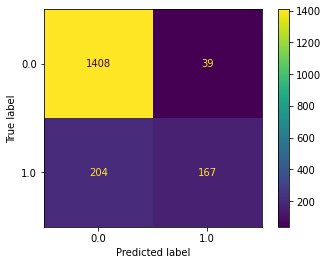

In [120]:
ConfusionMatrixDisplay(confusion_matrix(target_valid, predicted_valid), display_labels=model_RFC.classes_).plot()
None

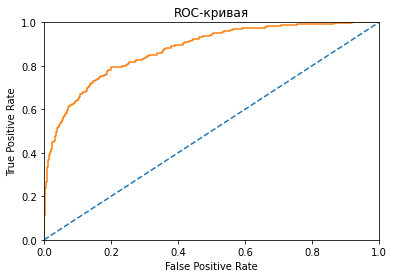

AUC ROC:0.875


In [88]:
probabilities_valid = model_RFC.predict_proba(features_valid)

probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

print(f'AUC ROC:{roc_auc_score(target_valid, model_RFC.predict_proba(features_valid)[:, 1]):.3}')

- Попробуем проварьировать порог разделения классов.

Порог = 0.36 | Точность = 0.665, Полнота = 0.620, f1-мера = 0.642


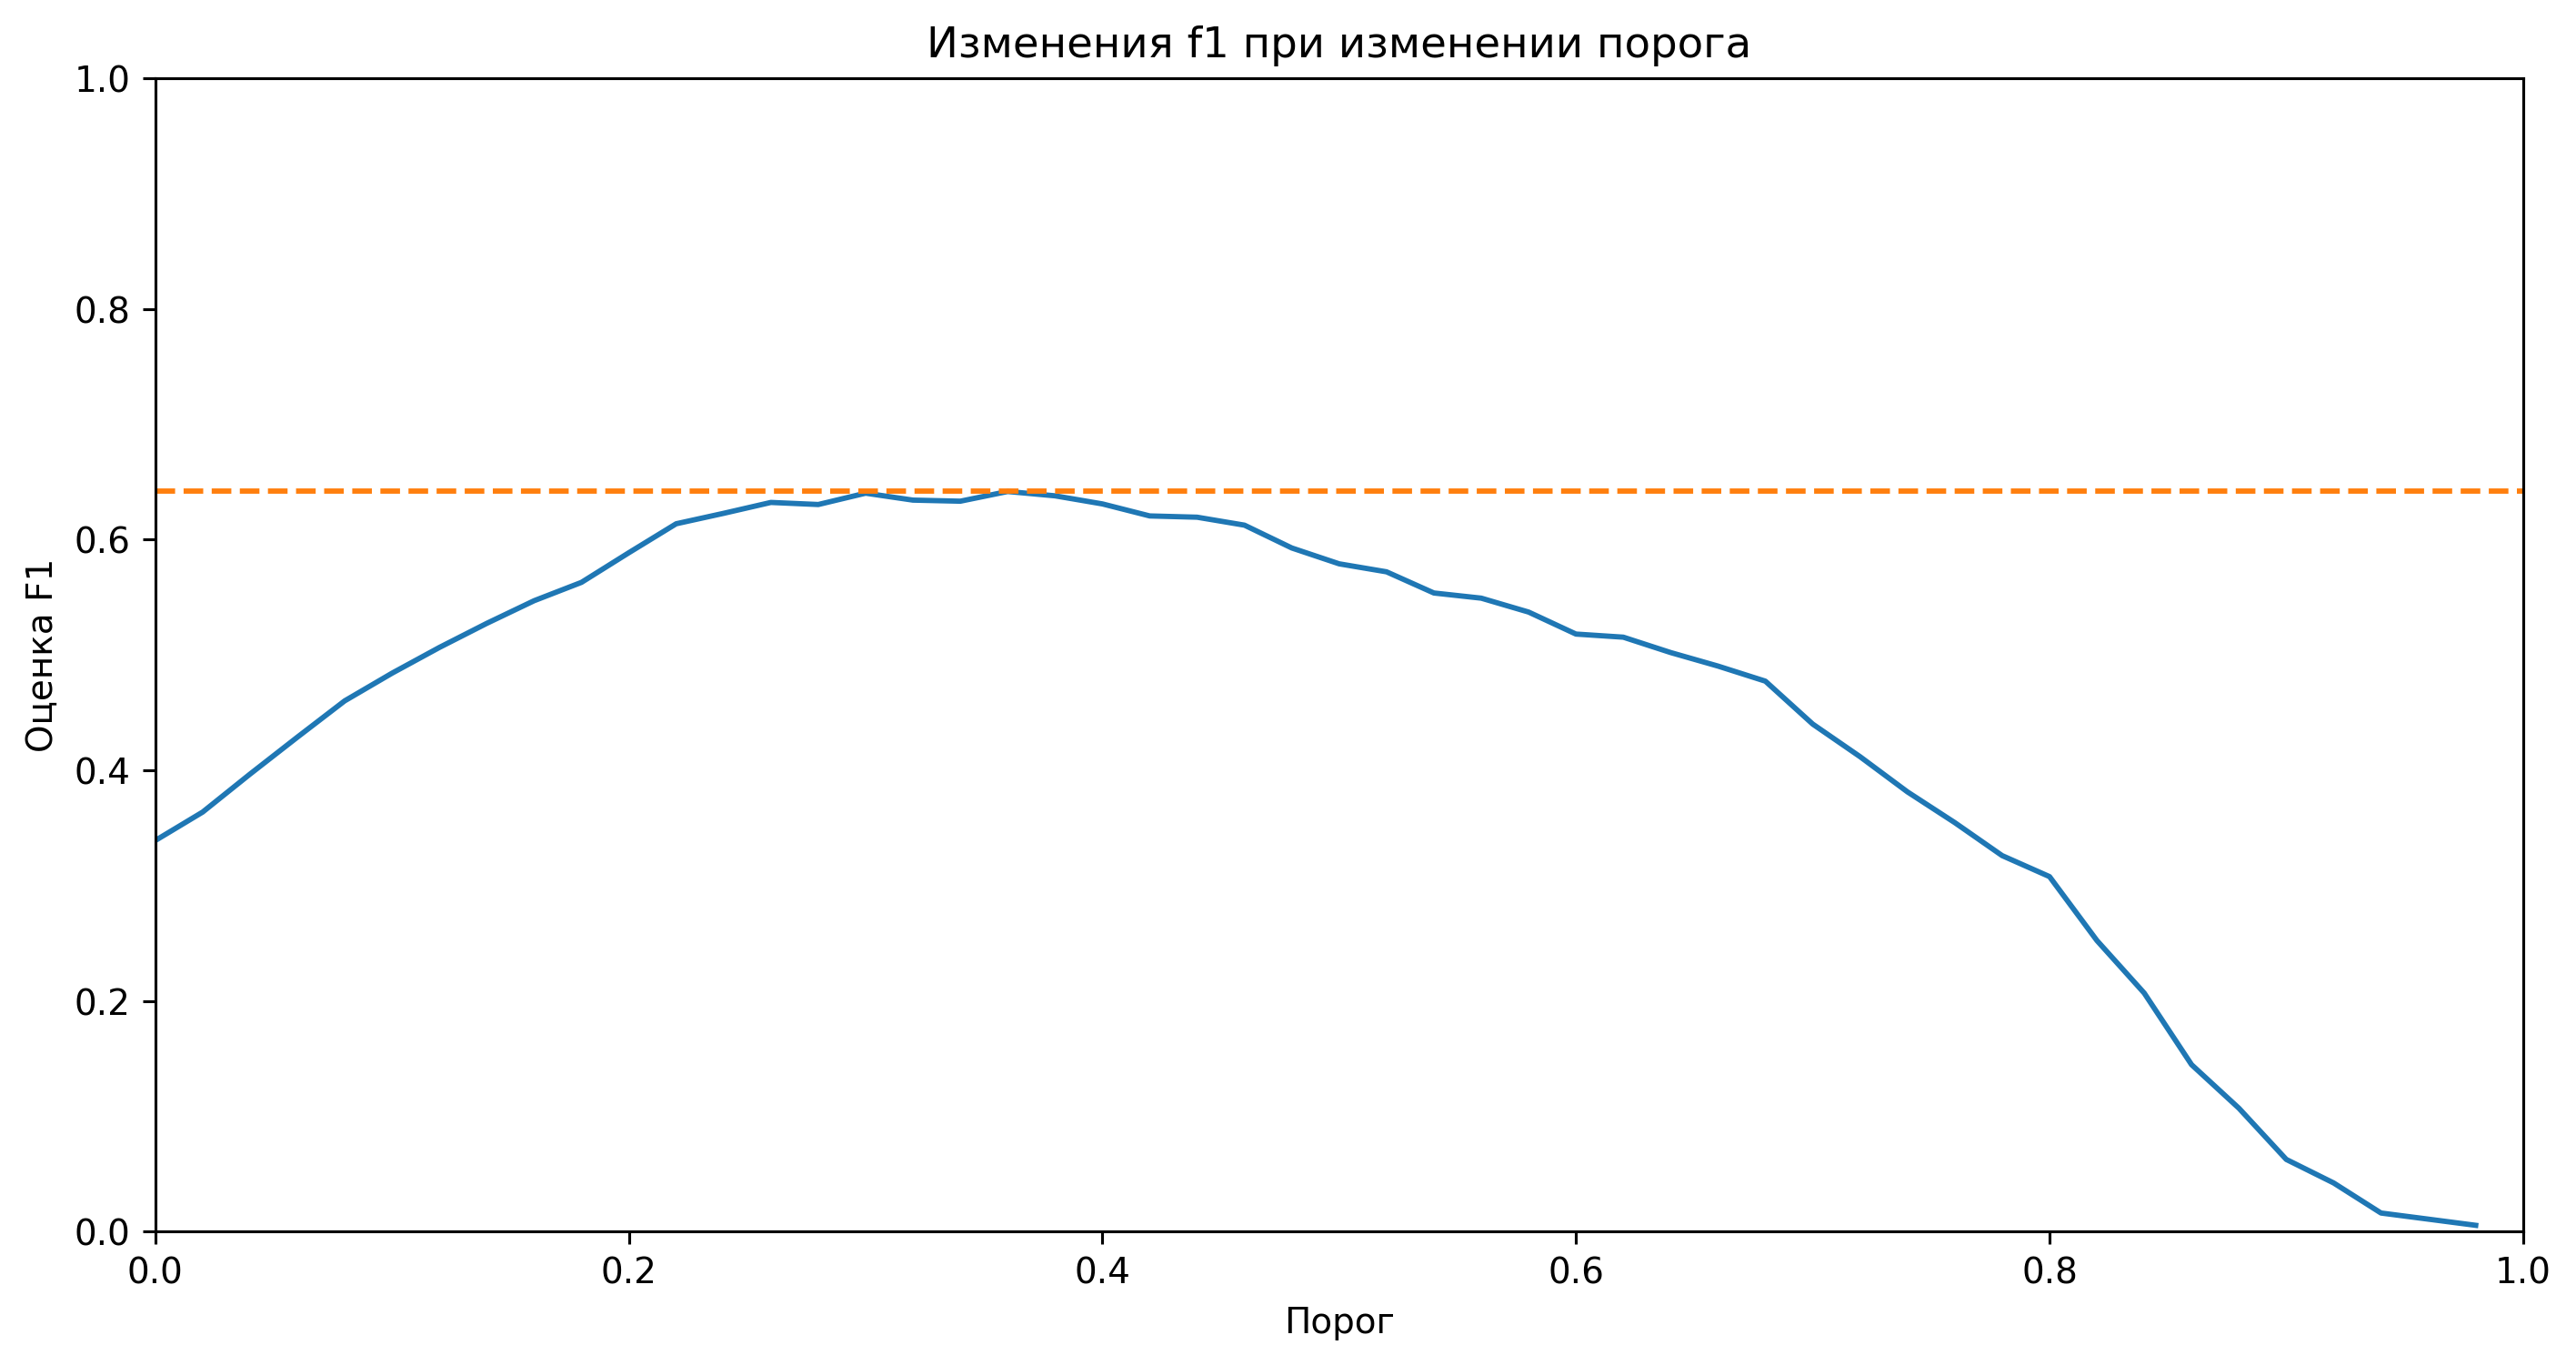

In [119]:
f1_list = []
threshold_list = []
precision_list = []
recall_list = []

for threshold in np.arange(0, 1, 0.02):
    predicted_valid_test = probabilities_one_valid > threshold 
    precision = precision_score(target_valid, predicted_valid_test)
    recall = recall_score(target_valid, predicted_valid_test)
    f1 = 2 * precision * recall / (precision + recall) 
    threshold_list.append(threshold)
    f1_list.append(f1)
    precision_list.append(precision)
    recall_list.append(recall)

   # print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, f1-мера = {:.3f}".format(
    #    threshold, precision, recall, f1))

_ = f1_list.index(max(f1_list))
print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, f1-мера = {:.3f}".format(
        threshold_list[_], precision_list[_], recall_list[_], f1_list[_]))

plt.figure(figsize=(12, 6), dpi=280)
plt.plot(threshold_list, f1_list)
plt.plot([0, 1],[f1_list[_], f1_list[_]], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Порог')
plt.ylabel('Оценка F1')
plt.title('Изменения f1 при изменении порога')

plt.show()


In [128]:
probabilities_valid = model_RFC.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
predicted_valid_test = probabilities_one_valid > threshold_list[_] 

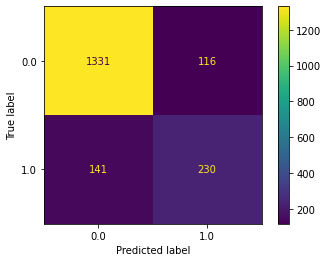

In [129]:
ConfusionMatrixDisplay(confusion_matrix(target_valid, predicted_valid_test), display_labels=model_RFC.classes_).plot()
None

Наша модель на валидационной выборке выявила только 167 покинувших банк клиента, и пропустила 204. Так же 39 клиентов она неверно определила, как желающих покинуть банк.
    
F1 мера близка к 0,579. У нас неплохая "точность", но очень плохая полнота (0.45). Это нам значительно снижает F1 меру.    
    
Сonfusion matrix показывает, что мы не очень много имеем false positive. Сама метрика достаоточно высокая - 0.875. Но наша основная проблема - очень много false negative. Мы не замечаем больше половины уходящих клиентов.  

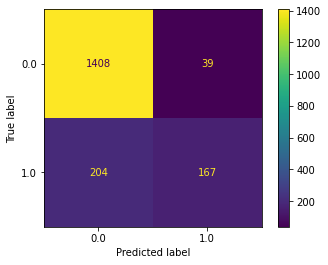
    

С помощью варьирования порога мы смогли повысить метрики, но при этом значительно увеличить количетсво ложно-положительных.
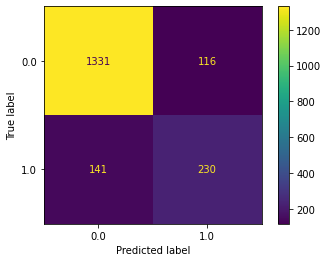

## Борьба с дисбалансом

- Создадим функции для увеличения и уменьшения выборок. Как мы знаем, порядка 20%, т.е. 1/5 покидает банк. Соответственно, 80 к 20 надо превратить в (80 * 0.5) к (20 * 2).

In [132]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=rnd)
    
    return features_upsampled, target_upsampled

In [133]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=rnd)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=rnd)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=rnd)
    
    return features_downsampled, target_downsampled

In [134]:
features_train, target_train = upsample(features_train, target_train, 2)

In [135]:
features_train, target_train = downsample(features_train, target_train, 0.5)

In [137]:
f"В ресемплированной выборке банк покинуло {target_train.mean():.1%} клиентов"

'В ресемплированной выборке банк покинуло 50.6% клиентов'

Точность: 0.8124312431243125
Полнота: 0.7358490566037735
Матрица ошибок для нашей модели :
[[1204  243]
 [  98  273]]
F1 мера: 0.6155580608793686


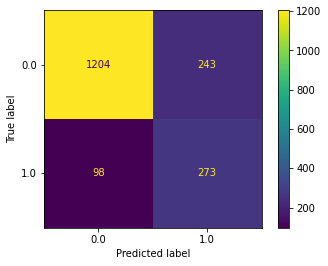

In [185]:
model_RFC.fit(features_train, target_train)
predicted_valid = model_RFC.predict(features_valid)

print('Точность:', model_RFC.score(features_valid, target_valid))
print('Полнота:', recall_score(target_valid, predicted_valid))
print('Матрица ошибок для нашей модели :') 
print(confusion_matrix(target_valid, predicted_valid))
print('F1 мера:', f1_score(target_valid, predicted_valid))
ConfusionMatrixDisplay(confusion_matrix(target_valid, predicted_valid), display_labels=model_RFC.classes_).plot()
None

- Проведем поиск новой модели для ресемплированной выборки.

```python
%%time
clf = RandomForestClassifier()

f1 = make_scorer(f1_score , average='macro')

parametrs = {'n_estimators': range (60, 161, 50),
              'max_depth': range (13,22, 3),
              'min_samples_leaf': range (1,12,2),
              'min_samples_split': range (2,11,2) }
grid = GridSearchCV(clf, parametrs, cv=3, verbose = 2, scoring=f1)
grid.fit(features_train, target_train)

grid.best_params_, grid.best_score_
```

```python
Fitting 3 folds for each of 270 candidates, totalling 810 fits
({'max_depth': 19,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 60},
 0.8629400038204889)
```

Точность: 0.828932893289329
Полнота: 0.692722371967655
Матрица ошибок для нашей модели :
[[1250  197]
 [ 114  257]]
F1 мера: 0.6230303030303029


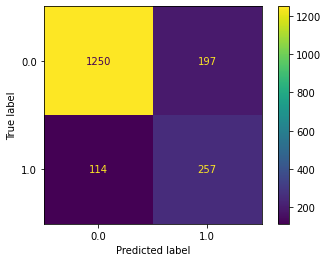

In [142]:
model_RFC2 = RandomForestClassifier(max_depth = 19, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 60)
model_RFC2.fit(features_train, target_train)
predicted_valid = model_RFC2.predict(features_valid)

print('Точность:', model_RFC2.score(features_valid, target_valid))
print('Полнота:', recall_score(target_valid, predicted_valid))
print('Матрица ошибок для нашей модели :') 
print(confusion_matrix(target_valid, predicted_valid))
print('F1 мера:', f1_score(target_valid, predicted_valid))
ConfusionMatrixDisplay(confusion_matrix(target_valid, predicted_valid), display_labels=model_RFC.classes_).plot()
None

- Новая модель на валидационной выборке работает хуже.

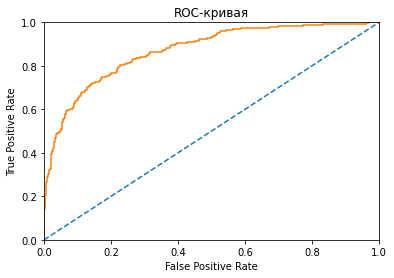

AUC ROC:0.871


In [147]:
probabilities_valid = model_RFC.predict_proba(features_valid)

probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

print(f'AUC ROC:{roc_auc_score(target_valid, model_RFC.predict_proba(features_valid)[:, 1]):.3}')

Порог = 0.64 | Точность = 0.676, Полнота = 0.596, f1-мера = 0.633


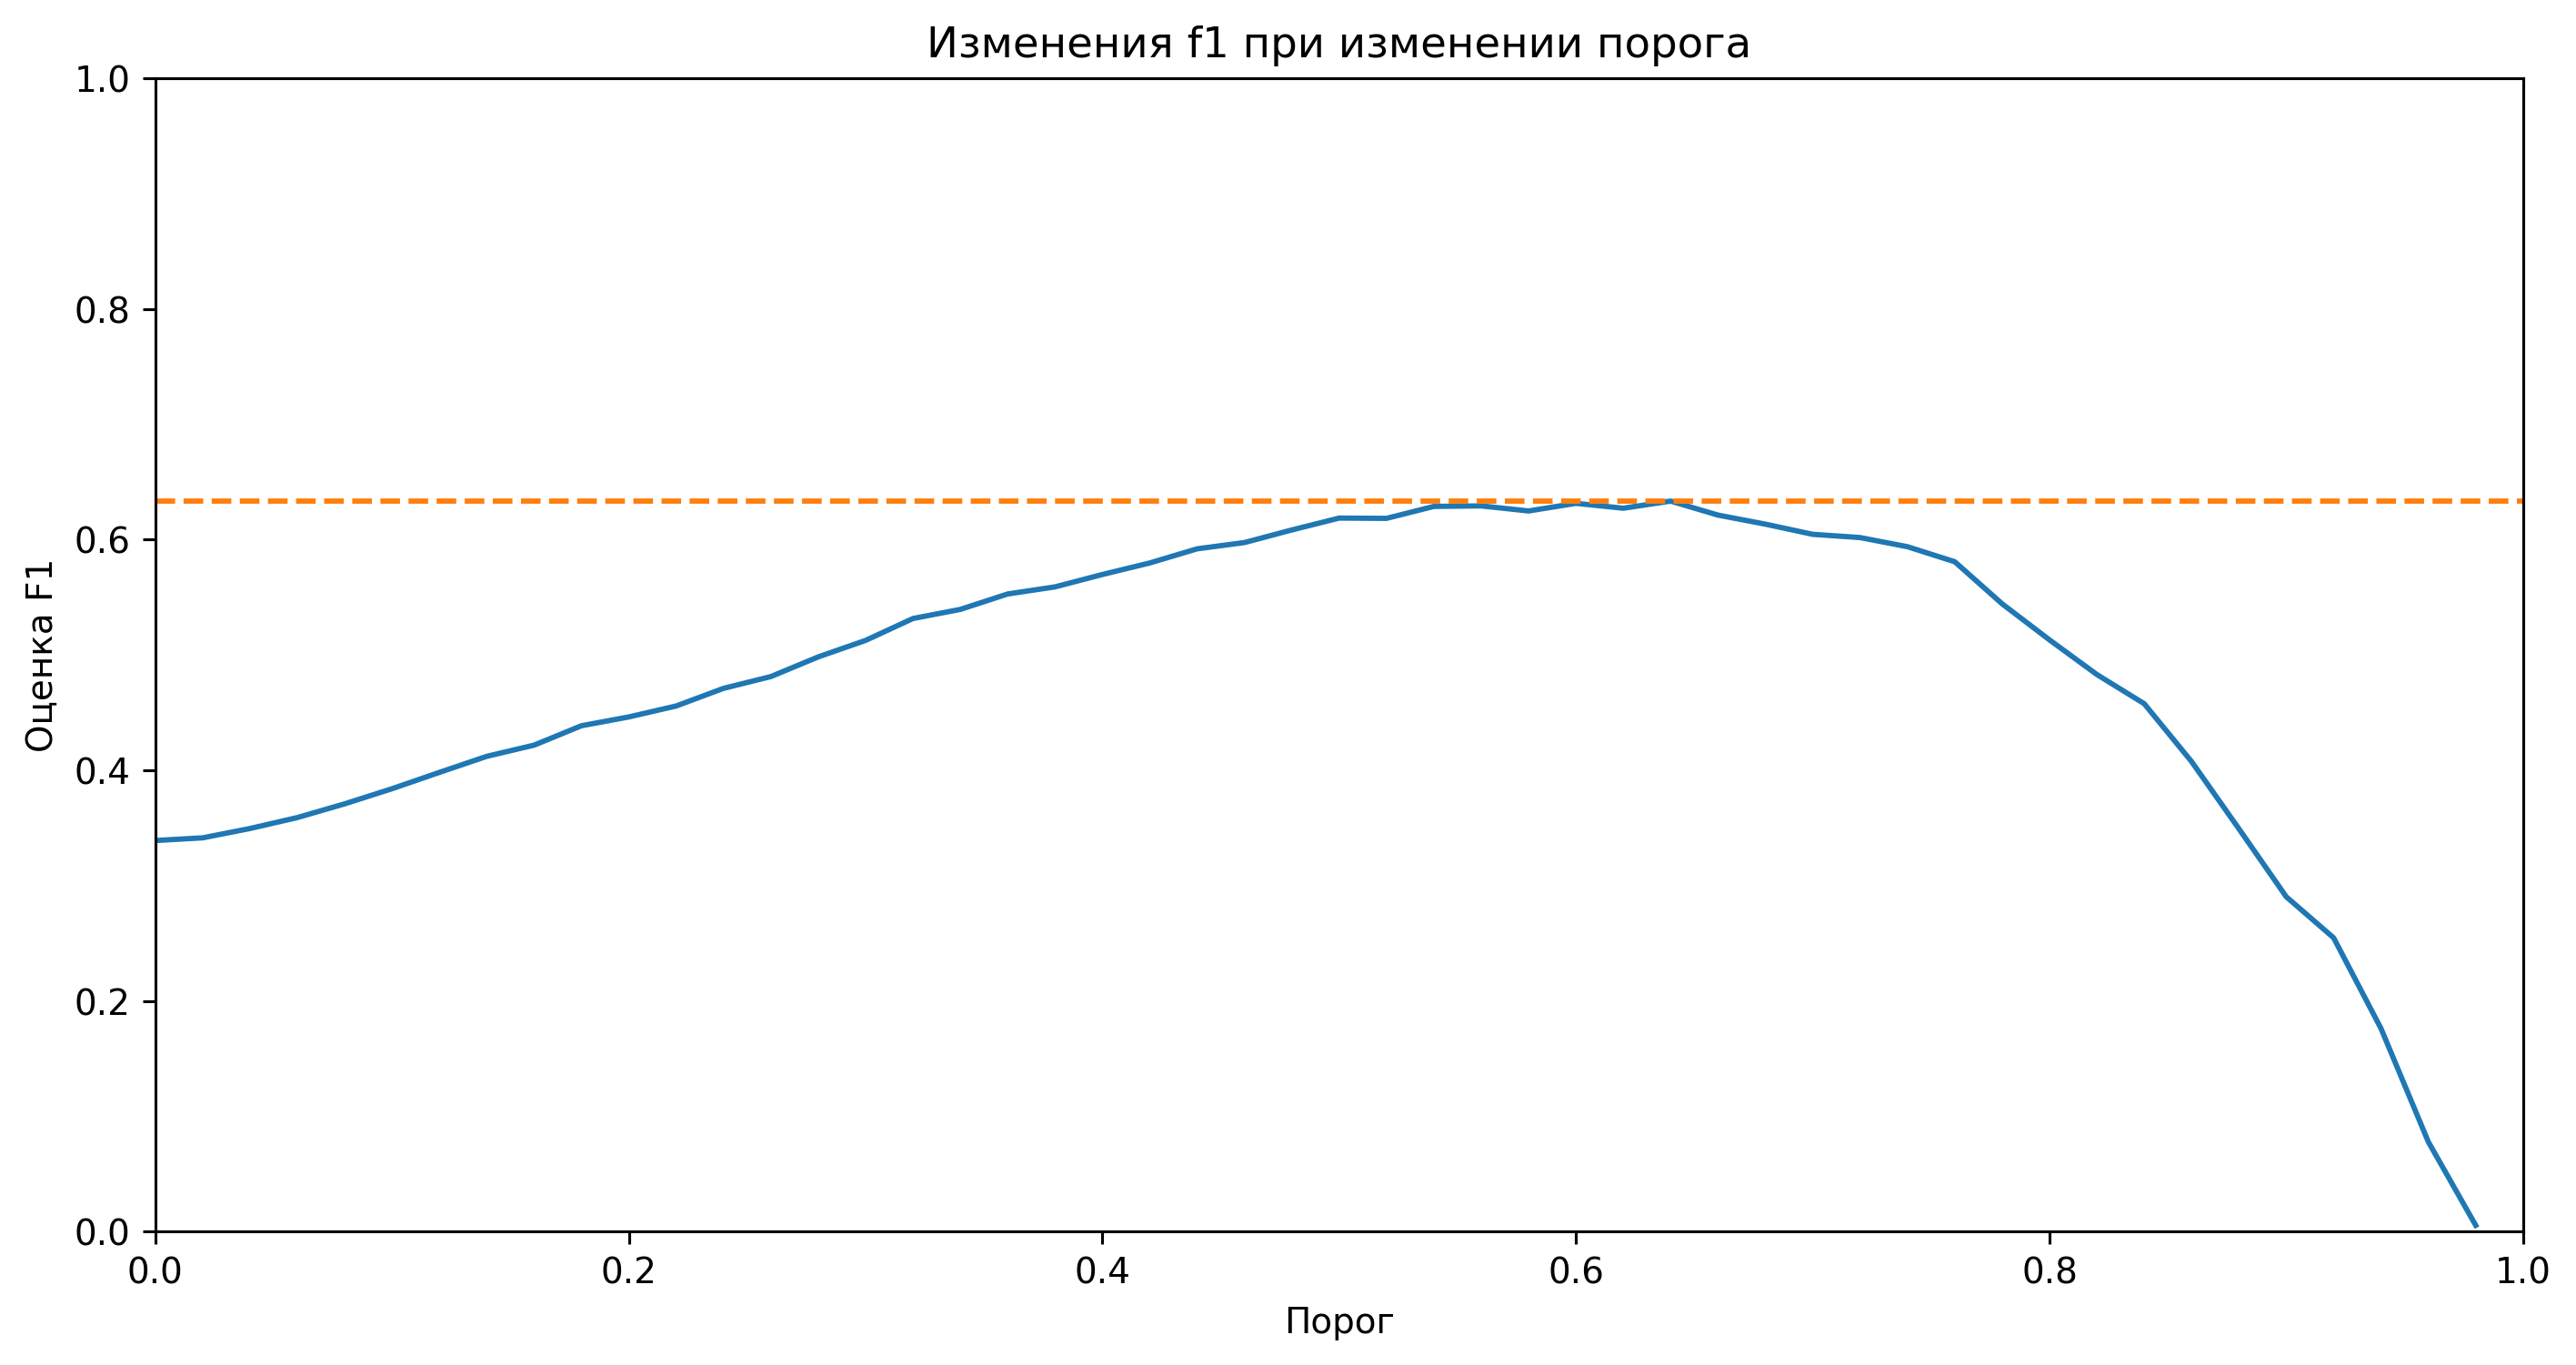

In [181]:
f1_list = []
threshold_list = []
precision_list = []
recall_list = []
probabilities_valid = model_RFC.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 1, 0.02):
    predicted_valid_test = probabilities_one_valid > threshold 
    precision = precision_score(target_valid, predicted_valid_test)
    recall = recall_score(target_valid, predicted_valid_test)
    f1 = 2 * precision * recall / (precision + recall) 
    threshold_list.append(threshold)
    f1_list.append(f1)
    precision_list.append(precision)
    recall_list.append(recall)

   # print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, f1-мера = {:.3f}".format(
    #    threshold, precision, recall, f1))

_ = f1_list.index(max(f1_list))
print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, f1-мера = {:.3f}".format(
        threshold_list[_], precision_list[_], recall_list[_], f1_list[_]))

plt.figure(figsize=(12, 6), dpi=280)
plt.plot(threshold_list, f1_list)
plt.plot([0, 1],[f1_list[_], f1_list[_]], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Порог')
plt.ylabel('Оценка F1')
plt.title('Изменения f1 при изменении порога')

plt.show()


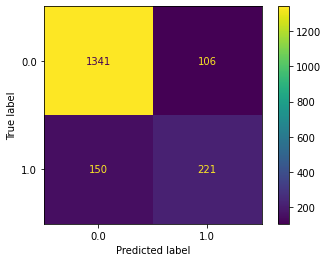

In [186]:
predicted_valid_test = probabilities_one_valid > threshold_list[_] 
ConfusionMatrixDisplay(confusion_matrix(target_valid, predicted_valid_test), display_labels=model_RFC.classes_).plot()
None

Точность: 0.8146314631463146
Полнота: 0.7601078167115903
Матрица ошибок для нашей модели :
[[1199  248]
 [  89  282]]
F1 мера: 0.6259711431742508


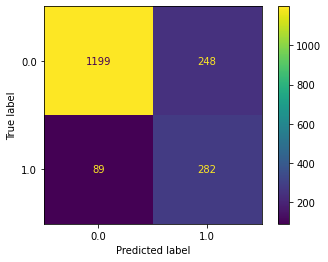

In [179]:
from catboost import CatBoostClassifier
model = CatBoostClassifier()
model.fit(features_train, target_train,verbose=False)
predicted_valid = model.predict(features_valid)

print('Точность:', model.score(features_valid, target_valid))
print('Полнота:', recall_score(target_valid, predicted_valid))
print('Матрица ошибок для нашей модели :') 
print(confusion_matrix(target_valid, predicted_valid))
print('F1 мера:', f1_score(target_valid, predicted_valid))
ConfusionMatrixDisplay(confusion_matrix(target_valid, predicted_valid), display_labels=model.classes_).plot()
None

### Подытог

Результаты на валидационной выборке:
    
Модель случайного леса:
    

    Точность: 0.812
    Полнота: 0.736
    Матрица ошибок для нашей модели :
    [[1204  243]
     [  98  273]]
    F1 мера: 0.616

Модель случайного леса после ресемплирования:
    
    Точность: 0.829
    Полнота: 0.693
    Матрица ошибок для нашей модели :
    [[1250  197]
     [ 114  257]]
    F1 мера: 0.623
    
Модель CatBoostClassifier:
    
    Точность: 0.815
    Полнота: 0.760
    Матрица ошибок для нашей модели :
    [[1199  248]
     [  89  282]]
    F1 мера: 0.626
    
Самыми лучшими параметрами обладает модель CatBoostClassifier. Помимо более высоких значений меры f1, у этой модели самое низкое значение false negative.


## Тестирование модели

### Лучшая модель

Точность: 0.811
Полнота: 0.704
Матрица ошибок для нашей модели :
[[1214  234]
 [ 110  261]]
F1 мера: 0.603
AUC-ROC метрика для модели случайный лес 0.857


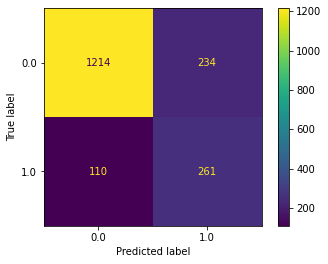

In [192]:
predicted_test = model.predict(features_test)

print('Точность:', round(model.score(features_test, target_test),3))
print('Полнота:', round(recall_score(target_test, predicted_test),3))
print('Матрица ошибок для нашей модели :') 
print(confusion_matrix(target_test, predicted_test))
print('F1 мера:', round(f1_score(target_test, predicted_test),3))
print('AUC-ROC метрика для модели случайный лес'
    ,round(roc_auc_score(target_test, model.predict_proba(features_test)[:, 1]),3))
ConfusionMatrixDisplay(confusion_matrix(target_test, predicted_test), display_labels=model.classes_).plot()
None

### Тестирование моделей, которые мы откинули

In [188]:
predicted_test = model_RFC.predict(features_test)

print('Точность:', model_RFC.score(features_test, target_test))
print('Полнота:', recall_score(target_test, predicted_test))
print('Матрица ошибок для нашей модели :') 
print(confusion_matrix(target_test, predicted_test))
print('F1 мера:', f1_score(target_test, predicted_test))
print('AUC-ROC метрика для модели случайный лес'
    ,roc_auc_score(target_test, model_RFC.predict_proba(features_test)[:, 1]))


Точность: 0.8053875755909841
Полнота: 0.6657681940700808
Матрица ошибок для нашей модели :
[[1218  230]
 [ 124  247]]
F1 мера: 0.5825471698113207
AUC-ROC метрика для модели случайный лес 0.8426047266608092


In [189]:
predicted_test = model_RFC2.predict(features_test)

print('Точность:', model_RFC2.score(features_test, target_test))
print('Полнота:', recall_score(target_test, predicted_test))
print('Матрица ошибок для нашей модели :') 
print(confusion_matrix(target_test, predicted_test))
print('F1 мера:', f1_score(target_test, predicted_test))
print('AUC-ROC метрика для модели случайный лес'
    ,roc_auc_score(target_test, model_RFC2.predict_proba(features_test)[:, 1]))

Точность: 0.8202308960967565
Полнота: 0.628032345013477
Матрица ошибок для нашей модели :
[[1259  189]
 [ 138  233]]
F1 мера: 0.587641866330391
AUC-ROC метрика для модели случайный лес 0.840160608181561


### Подытог

    Модель CatBoostClassifier показала лучший результат на тестовой выборке:
    
    Точность: 0.811
    Полнота: 0.704
    Матрица ошибок для нашей модели :
    [[1214  234]
     [ 110  261]]
    F1 мера: 0.603
    AUC-ROC метрика для модели случайный лес 0.857
    

### Вариант до-обучения модели на валидационной выборке перед тестированием

In [193]:
features_valid, target_valid = upsample(features_valid, target_valid, 2)
features_valid, target_valid = downsample(features_valid, target_valid, 0.5)

In [194]:
features_train = pd.concat([features_train] + [features_valid])
target_train = pd.concat([target_train] + [target_valid])
features_train, target_train = shuffle(
        features_train, target_train, random_state=rnd)

In [196]:
model.fit(features_train,target_train, verbose = False)

Точность: 0.808
Полнота: 0.698
Матрица ошибок для нашей модели :
[[1211  237]
 [ 112  259]]
F1 мера: 0.597
AUC-ROC метрика для модели случайный лес 0.858


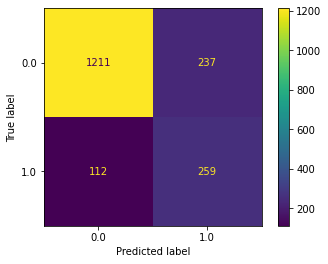

In [197]:
predicted_test = model.predict(features_test)

print('Точность:', round(model.score(features_test, target_test),3))
print('Полнота:', round(recall_score(target_test, predicted_test),3))
print('Матрица ошибок для нашей модели :') 
print(confusion_matrix(target_test, predicted_test))
print('F1 мера:', round(f1_score(target_test, predicted_test),3))
print('AUC-ROC метрика для модели случайный лес'
    ,round(roc_auc_score(target_test, model.predict_proba(features_test)[:, 1]),3))
ConfusionMatrixDisplay(confusion_matrix(target_test, predicted_test), display_labels=model.classes_).plot()
None

 - Качество модели ухудшилось в пределах погрешности.


### Вариант удаления столбца 'Tenure'

In [207]:
try:
    df = pd.read_csv('C://datasets/Churn.csv')
except:
    df = pd.read_csv('/datasets/Churn.csv')

In [209]:
df = df.drop(['RowNumber', 'CustomerId','Surname', 'Tenure'], axis=1)

df.head(10)

,CreditScore,Geography,Gender,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,125510.82,1,1,1,79084.10,0
5,645,Spain,Male,44,113755.78,2,1,0,149756.71,1
6,822,France,Male,50,0.00,2,1,1,10062.80,0
7,376,Germany,Female,29,115046.74,4,1,0,119346.88,1
8,501,France,Male,44,142051.07,2,0,1,74940.50,0
9,684,France,Male,27,134603.88,1,1,1,71725.73,0


In [211]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Balance          10000 non-null  float64
 5   NumOfProducts    10000 non-null  int64  
 6   HasCrCard        10000 non-null  int64  
 7   IsActiveMember   10000 non-null  int64  
 8   EstimatedSalary  10000 non-null  float64
 9   Exited           10000 non-null  int64  
dtypes: float64(2), int64(6), object(2)
memory usage: 781.4+ KB


In [212]:
df.columns = df.columns.str.lower()
df['geography'] = df['geography'].str.lower()
df['gender'] = df['gender'].str.lower()

df.head()

,creditscore,geography,gender,age,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,france,female,42,0.00,1,1,1,101348.88,1
1,608,spain,female,41,83807.86,1,0,1,112542.58,0
2,502,france,female,42,159660.80,3,1,0,113931.57,1
3,699,france,female,39,0.00,2,0,0,93826.63,0
4,850,spain,female,43,125510.82,1,1,1,79084.10,0


In [213]:
df = df.rename(columns={"creditscore": "credit_score", "numofproducts": "products", "hascrcard": "has_cr_card", 
                   "isactivemember": "is_active", "estimatedsalary": "estimated_salary" })
df.head()

,credit_score,geography,gender,age,balance,products,has_cr_card,is_active,estimated_salary,exited
0,619,france,female,42,0.00,1,1,1,101348.88,1
1,608,spain,female,41,83807.86,1,0,1,112542.58,0
2,502,france,female,42,159660.80,3,1,0,113931.57,1
3,699,france,female,39,0.00,2,0,0,93826.63,0
4,850,spain,female,43,125510.82,1,1,1,79084.10,0


In [214]:
convent_to_int_list = ['credit_score', 'age', 'balance', 'products', 'has_cr_card', 'is_active', 
            'estimated_salary', 'exited']

for x in convent_to_int_list:
    df[x] = df[x].astype('int', errors = 'ignore')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   credit_score      10000 non-null  int64 
 1   geography         10000 non-null  object
 2   gender            10000 non-null  object
 3   age               10000 non-null  int64 
 4   balance           10000 non-null  int64 
 5   products          10000 non-null  int64 
 6   has_cr_card       10000 non-null  int64 
 7   is_active         10000 non-null  int64 
 8   estimated_salary  10000 non-null  int64 
 9   exited            10000 non-null  int64 
dtypes: int64(8), object(2)
memory usage: 781.4+ KB


In [215]:
encoder = OrdinalEncoder() 
encoder.fit(df) 
df_ordinal = pd.DataFrame(encoder.transform(df), columns=df.columns) 
df_ordinal

,credit_score,geography,gender,age,balance,products,has_cr_card,is_active,estimated_salary,exited
0,228.0,0.0,0.0,24.0,0.0,0.0,1.0,1.0,4951.0,1.0
1,217.0,2.0,0.0,23.0,729.0,0.0,0.0,1.0,5506.0,0.0
2,111.0,0.0,0.0,24.0,5620.0,2.0,1.0,0.0,5572.0,1.0
3,308.0,0.0,0.0,21.0,0.0,1.0,0.0,0.0,4595.0,0.0
4,459.0,2.0,0.0,25.0,3583.0,0.0,1.0,1.0,3834.0,0.0
...,...,...,...,...,...,...,...,...,...,...
9995,380.0,0.0,1.0,21.0,0.0,1.0,1.0,0.0,4716.0,0.0
9996,125.0,0.0,1.0,17.0,123.0,0.0,1.0,1.0,4968.0,0.0
9997,318.0,0.0,0.0,18.0,0.0,0.0,0.0,1.0,2016.0,1.0
9998,381.0,1.0,1.0,24.0,421.0,1.0,1.0,0.0,4532.0,1.0


In [216]:
target = df_ordinal['exited']
features = df_ordinal.drop('exited', axis=1)

In [217]:
features_train, features_subset, target_train, target_subset = train_test_split(
    features, target, test_size=0.40, random_state=rnd, stratify = target)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_subset, target_subset, test_size=0.5, random_state=rnd, stratify = target_subset)

In [218]:
features_train, target_train = upsample(features_train, target_train, 2)
features_train, target_train = downsample(features_train, target_train, 0.5)

In [220]:
model.fit(features_train, target_train, verbose = False)
predicted_valid = model.predict(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print('Точность:', model.score(features_valid, target_valid))
print('Полнота:', recall_score(target_valid, predicted_valid))
print('Матрица ошибок для нашей модели :') 
print(confusion_matrix(target_valid, predicted_valid))
print('F1 мера:', f1_score(target_valid, predicted_valid))
print('AUC-ROC метрика для модели случайный лес'
    ,roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1]))

Точность: 0.8135
Полнота: 0.7794117647058824
Матрица ошибок для нашей модели :
[[1309  283]
 [  90  318]]
F1 мера: 0.6303270564915758
AUC-ROC метрика для модели случайный лес 0.8715790964627058


Точность: 0.796
Полнота: 0.72
Матрица ошибок для нашей модели :
[[1300  293]
 [ 114  293]]
F1 мера: 0.59
AUC-ROC метрика для модели случайный лес 0.858


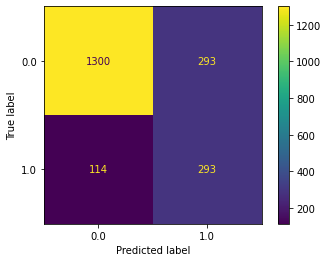

In [221]:
predicted_test = model.predict(features_test)

print('Точность:', round(model.score(features_test, target_test),3))
print('Полнота:', round(recall_score(target_test, predicted_test),3))
print('Матрица ошибок для нашей модели :') 
print(confusion_matrix(target_test, predicted_test))
print('F1 мера:', round(f1_score(target_test, predicted_test),3))
print('AUC-ROC метрика для модели случайный лес'
    ,round(roc_auc_score(target_test, model.predict_proba(features_test)[:, 1]),3))
ConfusionMatrixDisplay(confusion_matrix(target_test, predicted_test), display_labels=model.classes_).plot()
None

- Удаление данных ухудшает результат модели.

## Вывод

Лучше всего себя показала модель Catboost.
    
    RandomForestClassifier('max_depth': 11, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 60)
    
Параметры, полученные на тестовой выборке:
    

    Точность: 0.811
    Полнота: 0.704
    Матрица ошибок для нашей модели :
    [[1214  234]
     [ 110  261]]
    F1 мера: 0.603
    AUC-ROC метрика для модели случайный лес 0.857
    
   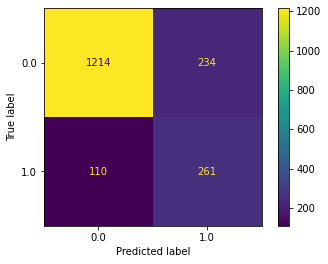
    
К сожелению, модель показывает много ложно-положительных результатов, что может повлечь излишние расходы на повышение лояльности клиентов, которые не собираются менять банк. При этом, с помощью балансировки классов мы смогли значительно снизить количество ложно-отрицательных предсказаний до 27%, что, возможно, поможет снизить отток клиентов. Это подтверждается высоким значением метрики AUC-ROC.